# 05 - Non-negative Matrix Factorization

In [1]:
from surprise import Dataset, evaluate, NMF, Reader

from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

sns.set(style='whitegrid')
% matplotlib inline

In [2]:
data_path = os.path.join('..','..','data')
data_file_100 = os.path.join(data_path, 'reviews_sample_100.csv')
data_file_50 = os.path.join(data_path, 'reviews_sample_50.csv')
data_file_25 = os.path.join(data_path, 'reviews_sample_25.csv')
data_file_10 = os.path.join(data_path, 'reviews_sample_10.csv')

df_100 = pd.read_csv(data_file_100).drop('Unnamed: 0', axis = 1)
df_50 = pd.read_csv(data_file_50).drop('Unnamed: 0', axis = 1)
df_25 = pd.read_csv(data_file_25).drop('Unnamed: 0', axis = 1)
df_10 = pd.read_csv(data_file_10).drop('Unnamed: 0', axis = 1)

In [3]:
reader = Reader(rating_scale=(1,5))
sdf_100 = Dataset.load_from_df(df_100[['reviewerID', 'asin', 'overall']], reader=reader)

In [4]:
def test_nmf(params): 
    model = NMF(**params)
    sdf_100.split(3, shuffle=True)
    results = evaluate(model, sdf_100, measures = ['mae'], verbose=True)
    mae = np.array(results['mae']).mean()
    return mae

In [14]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'trials_nmf'), 'rb') as file_in:
        trials = pkl.load(file_in)
    with open(os.path.join(data_path, 'best_nmf.dict'), 'rb') as file_in:
        best = pkl.load(file_in)
else:
    trials = Trials()
    space = {
        'n_factors': hp.choice('n_factors', list(range(10, 61))),
        'n_epochs': hp.choice('n_epochs', list(range(10,31))),
        'reg_pu': hp.uniform('reg_pu', 0, 0.1),
        'reg_qi': hp.uniform('reg_qi', 0, 0.1),
        'reg_bu': hp.uniform('reg_bu', 0, 0.1),
        'reg_bi': hp.uniform('reg_bi', 0, 0.1)
    }
    best = fmin(algo = tpe.suggest,
               fn = test_nmf,
               trials = trials,
               max_evals = 100,
               space = space)
    with open(os.path.join(data_path, 'trials_nmf'), 'wb') as file_out:
        pkl.dump(trials, file_out)
    with open(os.path.join(data_path, 'best_nmf.dict'), 'wb') as file_out:
        pkl.dump(best, file_out)

In [8]:
def val_diagnostic(val_name, trials):
    vals = np.array([trial['misc']['vals'][val_name] for trial in trials.trials])
    if val_name == 'n_epochs':
        vals += 10
    elif val_name == 'n_factors':
        vals += 10
    ts = [trial['tid'] for trial in trials.trials]
    results = [trial['result']['loss'] for trial in trials.trials]
    
    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    axes[0].scatter(ts, vals)
    axes[0].set(xlabel='iteration', ylabel=val_name)
    axes[1].hist(np.array(vals).squeeze())
    axes[1].set(xlabel=val_name, ylabel='frequency')
    axes[2].scatter(vals, results)
    axes[2].set(xlabel=val_name, ylabel='loss')
    plt.tight_layout()

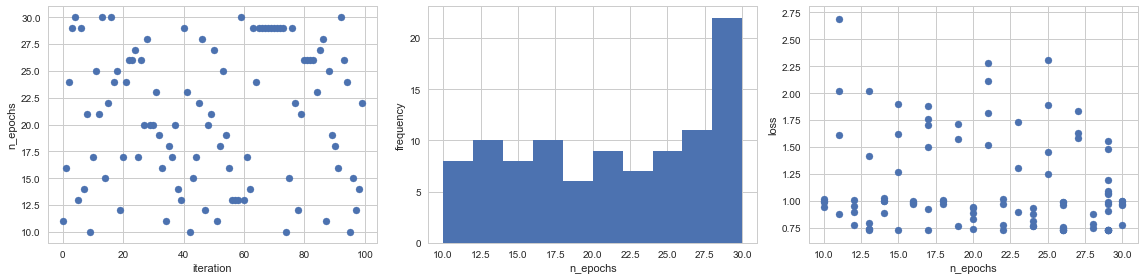

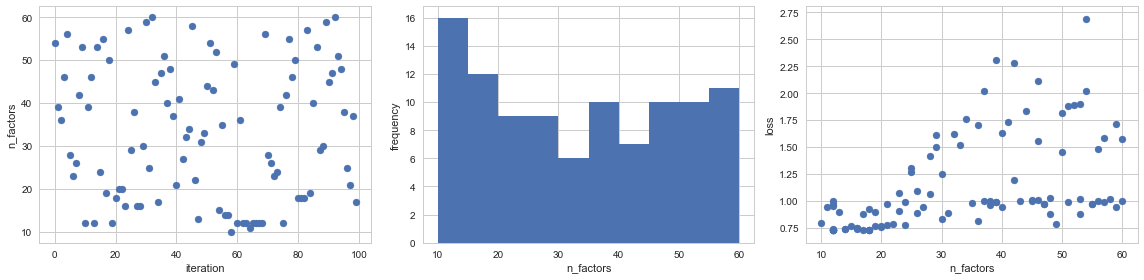

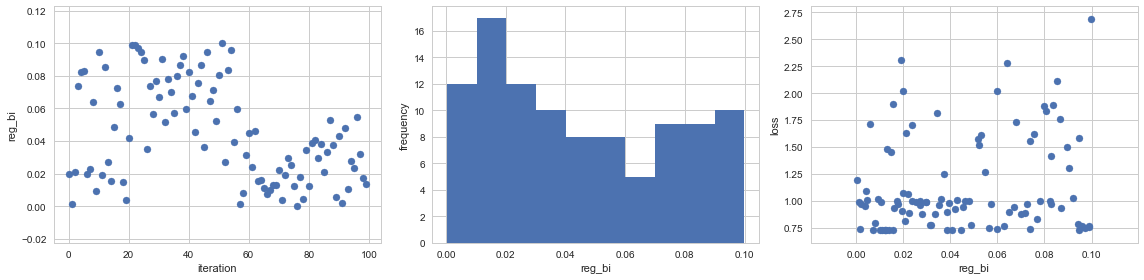

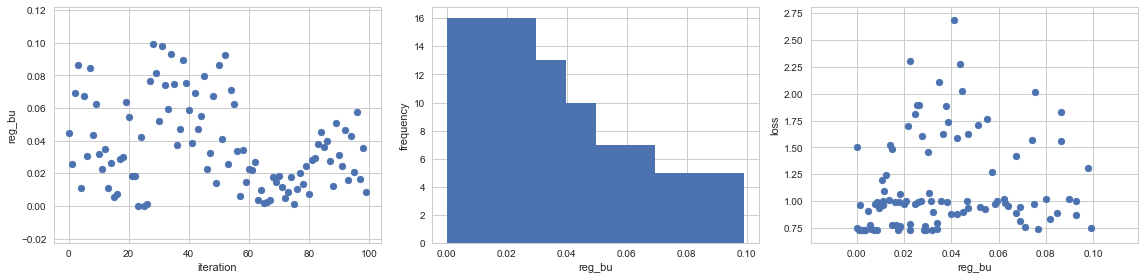

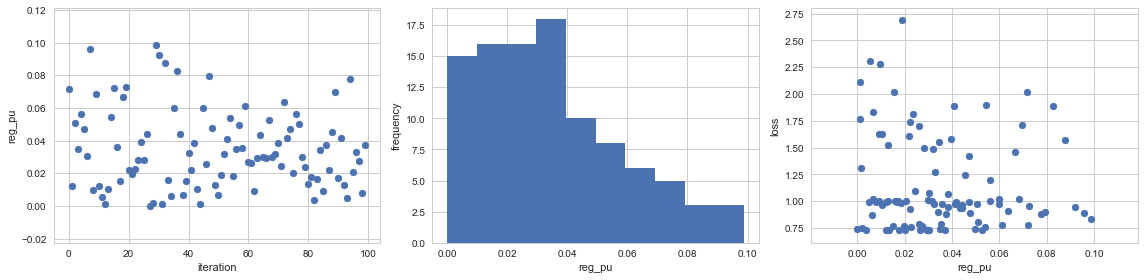

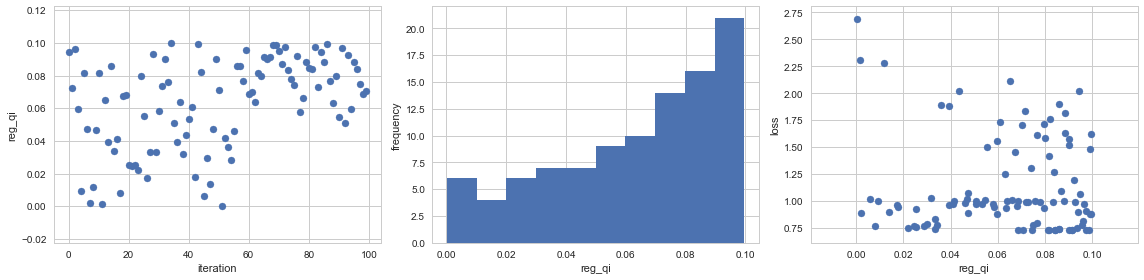

In [9]:
for val in trials.trials[0]['misc']['vals'].keys():
    val_diagnostic(val, trials)

In [15]:
if not use_pretrained:
    best_adjusted = best.copy()
    best_adjusted['n_epochs'] += 10
    best_adjusted['n_factors'] += 10
    with open(os.path.join(data_path, 'best_nmf.dict'), 'wb') as file_out:
            pkl.dump(best_adjusted, file_out)
else:
    best_adjusted = best.copy()

In [18]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'results_nmf.array'), 'rb') as file_in:
        results = pkl.load(file_in)
else:
    model = NMF(**best_adjusted)
    sdf_100.split(5)
    results = evaluate(model, sdf_100, measures = ['mae'])
    with open(os.path.join(data_path, 'results_nmf.array'), 'wb') as file_out:
        pkl.dump(results, file_out)

Evaluating MAE of algorithm NMF.

------------
Fold 1
MAE:  0.7177
------------
Fold 2
MAE:  0.7194
------------
Fold 3
MAE:  0.7238
------------
Fold 4
MAE:  0.7211
------------
Fold 5
MAE:  0.7251
------------
------------
Mean MAE : 0.7214
------------
------------


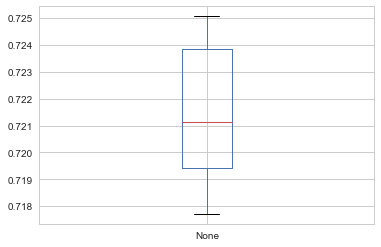

In [19]:
pd.Series(results['mae']).plot(kind = 'box')

# Runtime analysis

In [52]:
df_list = [df_10, df_25, df_50, df_100]

use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'runtime_nmf.list'), 'rb')as file_in:
        runtime_list = pkl.load(file_in)
else:
    runtime_list = list()
    for df in df_list:
        sdf = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader=reader)
        train = sdf.build_full_trainset()

        start = time.time()
        model.train(train)
        end = time.time()

        runtime_list.append(end-start)

    with open(os.path.join(data_path, 'runtime_nmf.list'), 'wb')as file_out:
        pkl.dump(runtime_list, file_out)

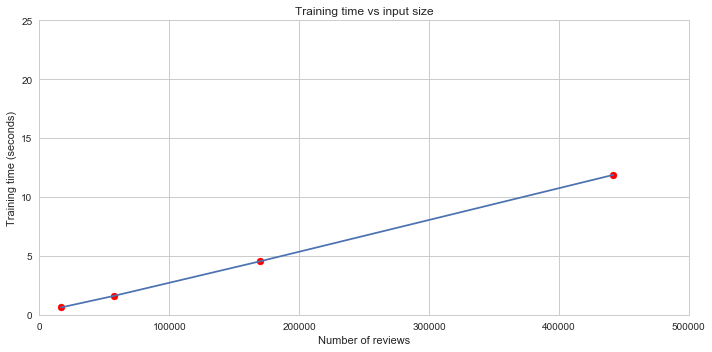

In [53]:
n_reviews_list = [len(df) for df in df_list]
plt.figure(figsize = (10, 5))
plt.plot(n_reviews_list, runtime_list)
plt.scatter(n_reviews_list, runtime_list, color = 'red')
plt.ylim(0, 25)
plt.xlim(0, 500000)
plt.xlabel('Number of reviews')
plt.ylabel('Training time (seconds)')
plt.title('Training time vs input size')
plt.tight_layout()